The goal of this code is to develop a network, $g$ that can learn functions $f_t: \mathbb{R}^n -> \mathbb{R}^M$.  The idea is there will be a series of functions for $t = 0, 1, \ldots$ and we will sequentially train the same network to learn $f_0$, then $f_1$, etc...

The challenge will be that some $f_i = 0$ and we are not permitted to reinitiaize $g$ before when going from learning $f_i$ to learning $f_{i+1}$.  Essentially, the challenge is we need a network $g$ that can learn any $f_{t+1}$ after it is has learned any $f_t$, even when $f_t$ is the zero function. 

This exercise is useful because in variational inference we may have to learn a representation of a prior distribution.  Through the course of training, the optimal prior may change (optimal with respect to the current parameters of the likelihood models) and may (at the start) be flat.  It is beneficial to have a robust way of learning the optimal prior 


In [1]:
%load_ext autoreload
%autoreload 2

In [278]:
from typing import Callable, Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import SumOfTiledHyperCubeBasisFcns
from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.utils import torch_mod_to_fcn

## Define objects and functions we will use throughout the code

Define an object for generating $f_t$ functions.  For the moment, the functions will differ only in a scale term.

In [3]:
class F_t():
    """
    An object for generating a sequence of functions on the unit hypercube. 
    
    The function f_t is formed as t*f_base, where f_base is a base function
    made up of a sum of Gaussian bumps.  
    
    Bump centers will be uniformly distributed throughout the hypercube.  Bump
    magnitudes and shapes (how fast they fall off in different directions) will
    be randomly generated according to parameters set by the user. 
    
    """
    
    def __init__(self, d: int = 2, n_bumps: int = 100, 
                 bump_peak_vl_range: Sequence[int] = [-1, 1], 
                 cov_ev_range: Sequence[int] = [.5, 1]):
        """
        Creates a new F_t object. 
    
        Args:
            d: The input dimensionality. 
        
            n_bumps: The number of Gaussian bumps in the base function. 
        
            bump_peak_vl_range: Values for the peak of each bump function will be pulled
            uniformly from this interval. 
        
            cov_ev_range: Values for the eigenvalues of the covariance matrix of the 
            Gaussian bump functions will be pulled uniformly from this range. 
    
        """
    
        self.d = d
        self.n_bumps = n_bumps
        
        self.ctrs = np.random.uniform(size=[n_bumps, d])
        self.peak_vls = np.random.uniform(low=bump_peak_vl_range[0], 
                                          high=bump_peak_vl_range[1],
                                          size=n_bumps)
        
        # Generate the covariance for each bump function 
        eig_vls = np.random.uniform(low=cov_ev_range[0], 
                                          high=cov_ev_range[1],
                                          size=[n_bumps, d])
        
        inv_covs = np.zeros([d, d, n_bumps])
        for b_i in range(n_bumps):
            # Generate a random orthogonal matrix 
            u_i = np.linalg.svd(np.random.randn(d,d))[0]
            eig_vls_i = np.diag(1/eig_vls[b_i,:])
            inv_covs[:,:, b_i] = np.matmul(np.matmul(u_i, eig_vls_i), u_i.transpose())
            
        self.inv_covs = inv_covs
        
    def _f(self, x: np.ndarray) -> np.ndarray:
        """ Computes output given input. 
           
        Args:
            x: input of shape n_smps*d_in.  
            
        Returns:
            y: output of shape n_smps
        """
        
        n_smps = x.shape[0]
        
        y = np.zeros(n_smps)
        
        for b_i in range(self.n_bumps):
            x_ctr = x - self.ctrs[b_i,:]
            
            inv_cov_i = np.squeeze(self.inv_covs[:, :, b_i])
            
            temp = np.squeeze(np.sum(np.matmul(x_ctr, inv_cov_i.transpose())*x_ctr,1))
            
            y += self.peak_vls[b_i]*np.exp(-1*temp)
        
        return y
    
    def generate(self, scale: float = 1.0) -> Callable:
        """ Generates a function at a given scale. 
        
        Args:
            f: The scale to generate the function at
        """
        
        def s_f(x):
            return scale*self._f(x)
        
        return s_f

In [4]:
def generate_pts(d: int = 2, n_smps_per_dim = 100):
    """ Generates points on a hyper grid for evaluating a function.
    
    Args:
        d: The dimensionality of the grid. 
        
        n_smps_per_dim: The number of samples per dimension to generate. 
    """
    
    dim_coords = (1/n_smps_per_dim)*np.arange(n_smps_per_dim)
    all_coords = [dim_coords]*d
    grid_coords = np.meshgrid(*all_coords)
    coords = np.stack([np.ravel(g) for g in grid_coords]).transpose()
    
    return coords
    

In [5]:
def plot_2d_f(f: Callable, n_smps_per_dim = 100):
    """ Plots a 2-d function on the unit square. 
    
    Args:
        f: The function to plot
        
        n_smps_per_dim: The number of samples per dimension to use when generating
        a grid to use for visualizing the function. 
    """
    
    pts = generate_pts(d = 2, n_smps_per_dim=n_smps_per_dim)  
    
    y_grid = f(pts).reshape([n_smps_per_dim, n_smps_per_dim])
    
    plt.imshow(y_grid)
    plt.colorbar()
    

In [124]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    for i in range(n_its):
        
        optimizer.zero_grad()
        
        y_pred = nn(x)
        er = torch.sum((y - y_pred)**2)
        
        er.backward()
        optimizer.step()
        
        if i % 100 == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Code for the new networks we are testing

In [141]:
class basic_layer(torch.nn.Module):
    
    def __init__(d_in: int = 2, d_out: int = 1, n_units: int = 100):
        pass

## Testing code goes here

In [365]:
f_generator = F_t(n_bumps=10, cov_ev_range=[.01, .02], bump_peak_vl_range=[-10, 10])

In [366]:
f_t = f_generator.generate(1.0)

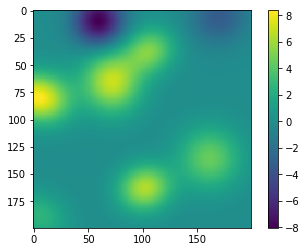

In [367]:
plot_2d_f(f_t, n_smps_per_dim=200)

In [376]:
f_fit = SumOfTiledHyperCubeBasisFcns(n_divisions_per_dim=[100, 100], 
                                     dim_ranges=np.asarray([[0, 1], [0,1]]),
                                     n_div_per_hc_side_per_dim = [3, 3])

In [381]:
f_fit = torch.nn.Sequential(torch.nn.Linear(in_features=2, out_features=500), 
                            torch.nn.ReLU(), 
                            torch.nn.Linear(in_features=500, out_features=10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=10, out_features=1))

In [364]:
n_layers = 3
growth_rate = 30
dense_out = 2 + n_layers*growth_rate


f_fit = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, d_in=2, 
                                        n_layers=n_layers, growth_rate=growth_rate, bias=True),
                            torch.nn.Linear(in_features=dense_out, out_features=1))

In [382]:
x_eval = torch.Tensor(generate_pts(n_smps_per_dim=100))
y_eval = f_t(x_eval.numpy())

y_eval_tensor = torch.Tensor(np.reshape(y_eval, [len(y_eval), 1]))

In [386]:
fit(f_fit, x_eval, y_eval_tensor, lr=.01)

It 0: 2.224748e+03
It 100: 2.253908e+03
It 200: 2.010549e+03
It 300: 1.804384e+03
It 400: 1.598115e+03
It 500: 1.399185e+03
It 600: 1.213542e+03
It 700: 1.053465e+03
It 800: 9.535993e+02
It 900: 2.210920e+03


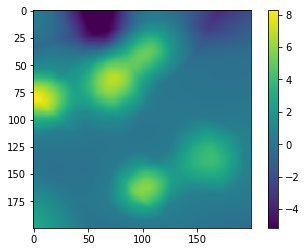

In [387]:
plot_2d_f(torch_mod_to_fcn(f_fit), n_smps_per_dim=200)